<a href="https://colab.research.google.com/github/jiwoong2/deeplearning/blob/main/Opimizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np

# SGD(Stochastic Gradient Decent)

확률적 경사하강법: 전체 데이터셋을 한번에 학습 시키는 것은 많은 컴퓨팅 자원을 필요로 하는 일 이기 때문에 데이터셋을 분할해서 학습을 진행하는 것을 확률적 경사하강법이라고 한다. SGD는 오차함수의 상수인 데이터가 계속해서 변하게 되므로 하강궤적이 불안정하게 된다. 하지만 계산속도가 훨씬 빠르고, 여러번 반복할 경우 원래 결과로 수렴한다. 그리고 Local minimum에 빠지지 않고 더 좋은 방향으로 수렴할 가능성도 높다.

In [ ]:
class SGD:

    def __init__(self, lr=0.01):
        self.lr = lr

    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

# Momentum

물리학의 관선에서 아이디어를 얻어 적용한 기법으로 Gradient Decent에서 방향과 학습률을 적용했다면 Momentum에서는 관성을 추가하게 된다. 정확히는 이전 스텝의 기울기 크기를 고려해 추가이동하게 된다. Gradient Decent는 초기값에 따라 Local minimum이나 plateau에서 학습이 진행돼지 않는 문제가 있는 반해 Momentum은 관성을 이용해 빠져나올 수 있게 된다.
또 매개변수간 변화율의 차이가 크게 되는 경우 Gradient Decent의 궤적이 진동하며 매우 비효율적인 동선을 보이는데 Momentum을 사용하게 되면 이런 문제점도 약간 개선된다.
\
\
점화식은

$V_{n} = \alpha V_{n-1} - \eta \bigtriangledown f(x_n) $

$V_{-1} = 0 $

$X_{n+1} = X_n + V_n$
\
\
물리계에 비유하면 $\alpha V_{n-1}$가 관성이 되고, $\alpha$ 는 관성계수가 된다.

Momentum의 문제점으로는 Overshooting문제가 있다. 관성을 통해 Local minimum 구간을 통과할 수 있듯이 Globalminimum(최적해)구간도 통과할 수 있는 것 이다.

In [ ]:
class Momentum:

    def __init__(self, lr = 0.01, momentum = 0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None

    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)

        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]

# NAG(Nesterov Accelated Gradient)

Momentum은 현재위치에서 관성과 Gradient의 반대방향을 합한다.
NAG는 Momentume을 공격적으로 변환한다. 현재위치에서 관성과 관성방향으로 움직인 후의 Gradient의 반대방향을 합하게 된다.

점화식은

$V_{n} = \alpha V_{n-1} - \eta \bigtriangledown f(x_n + \alpha V_{n-1}) $

$V_{-1} = 0 $

$X_{n+1} = X_n + V_n$

하지만 이 NAG는 $X_n$이 아닌 다른점에서 Gradient를 구하기 때문에 오차역전파를 사용하는 신경망에서는 구현하기 적합하지 않다. 대신 Bengio의 근사적 접근을 사용할 수 있다.

Bengio의 근사적 접근은 $X_n$의 궤적 대신 $X_n'$(관성방향으로 움직인 후의 지점)의 궤적으로 Gradient Dsent를 진행한다. 그러면 파라미터를 수정하지 않아도 되고 최종적으로는 관성이 줄어들며 $X_n$ 과 $X_n'$이 서로 근하하게 되므로 신경망에서 사용하기 적합하게 되는 것 이다.

?? gredient지점이 x'에서 x로 바뀌는 이유가 뭔지 모르겠음.

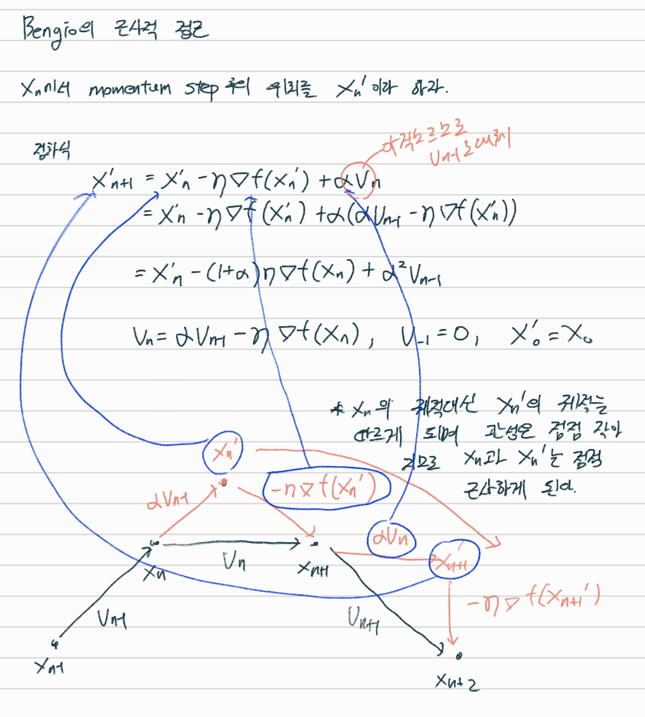

In [ ]:
class Nesterov:

    def __init__(self, lr = 0.01, momentum = 0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None

    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)

        for key in params.keys():
            self.v[key] *= self.momentum
            self.v[key] -= self.lr * grads[key]
            params[key] += self.mometum * self.momentum * self.v[key]
            params[key] -= (1 + self.momentum) * self.lr * grads[key]

# AdaGrad(Adaptive Gradients)


AdaGrad는 일정한 learning rate를 사용하지 않고 각 변수마다 그리고 매 step마다 다른 learning rate를 사용한다. leaning rate의 방향성은 매 step마다, 큰 변화를 겪을때마다 작아진다.

점화식

$h_n = h_{n-1} + \bigtriangledown f(x_n) \odot \bigtriangledown f(x_n),$

$h_{-1} = 0$

$x_{n+1} = x_n - \eta \frac{1}{\sqrt{h_n}} \odot \bigtriangledown f(x_n) $

점화식을 보면 $h_n$은 학습이 진행될수록 계속해서 커지며, 학습중에 큰 gradient값이 나오면 후에 계속해서 영향을 준다는 것을 알 수 있다.(계속 더해가기 떄문에) 이는 큰 변화를 겪은 변수는 이미 최적에 가까워졌고 작은 변화를 겪은 변수는 최적에서 아직 멀다고 생각하기 때문이다.

In [ ]:
class AdaGrad:

    def __init__(self, lr = 0.01):
        self.lr = lr
        self.h = None

    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)

        for key in params.keys():
            self.h[key] += grads[key] * grads[key] # hadamard product.
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7) # 1e-7은 erorr방지.

# RMSProp(Root Mean Sqaure Propagation)

*AdaGrad는* 스텝이 많이 진행되면 누적치 $h_n$이 너무 커져서 학습률이 작이져 학습이 거의 되지 않는 문제가 있다. 이를 보완하기 위해 RMSProp은 이전 누적치와 현재 gradient의 좌표별 제곱의 가중치 평균을 생각한다. 이는 AdaGrad보다 최근 값을 더 반영하게 해준다.

점화식은

$h_n = \gamma h_{n-1} + (1-\gamma)\bigtriangledown f(x_n) \odot \bigtriangledown f(x_n),$

$h_{-1} = 0$

$x_{n+1} = x_n - \eta \frac{1}{\sqrt{h_n}}\odot\bigtriangledown f(x_n)$

$\gamma$는 forgetting factor또는 decay rate이라고 하며 클수록 과거가 중요하고 작을수록 현재가 중요하다.

In [ ]:
class RMSprop:

    def __init__(self, lr=0.01, decay_rate=0.99):
        self.lr = lr
        self.decay_rate = decay_rate
        self.h = None

    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)

        for key in params.keys():
            self.h[key] *= self.decay_rate
            self.h[key] += (1-self.decay_rate) * grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

# Adam

Momentum과 BMSProp 두가지 방식을 혼합한 형식의 optimizer. 따라서 복잡하지만 현재 가장 많이 사용되는 optimizer이다.

Momentum을 변형하여

$m_n = \beta_1 m_{n-1} + (1-\beta_1) \bigtriangledown f(x_n)$

$m_{-1} = 0$

Adagrad를 변형하여

$v_n = \beta_2 v_{n-1} + (1-\beta_2)\bigtriangledown f(x_n) \odot \bigtriangledown f(x_n)$

$v_{-1} = 0$

을 생각한다.

초기 값이 0이기 떄문에 $\beta_1, \beta_2$ 가 1에 가까우면 0으로 편향되기 떄문에 이를 보정하기위해 $\hat{m}_n = \frac{m_n}{1 - \beta _1 ^ {n+1}}, v_n = \frac{v_n}{1- \beta _2 ^{n+1}}$ 을 생각한다.

점의 이동 점화식은

$x_{n+1} = x_n - \eta \frac{1}{\sqrt{\hat{v}_n}} \odot m_n$

In [ ]:
class Adam:

    def __init__(self, lr = 0.001, beta1 = 0.9, beta2 = 0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None

    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}

            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)

        self.iter += 1
        lr_t = self.lr * np.sqrt(1.0 - self.beta2 ** self.iter) / (1.0 - self.beta1 ** self.iter)

        for key in params.keys():
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])

            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)

test, 문제검산

In [ ]:
eve = Adam(1. ,1/2, 1/2)

params = {'x' : 1., 'y' : 2.}
grads = {'x' : 2., 'y' : 1.}
eve.update(params, grads)

In [ ]:
eve.m

In [ ]:
eve.v

In [ ]:
params

# 옵티마이저 비교